# TRACE34 Demo

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [5]:
import os
os.chdir('/home/ludovicobartoli/Documents/Shapelets')
import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler, length_normalized_distance
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [6]:
data_name = "Trace"
X_train = np.load(f'demo/data/{data_name}_train.npy')
y_train = np.load(f'demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'demo/data/{data_name}_test.npy')
y_test = np.load(f'demo/data/{data_name}_test_labeles.npy')

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

Shape of training data: (100, 275, 1)
Shape of test data: (100, 275, 1)
The different classes: {1, 2, 3, 4}


### Preprocessing

#### Get statistics of the entire data:

In [7]:
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of the total data: (200, 275, 1)
Number of total samples in each class: [50, 50, 50, 50]


Plot one sample per class:

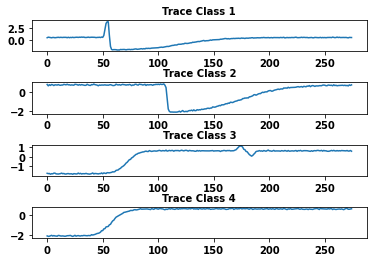

In [8]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

In [9]:
np.random.seed(0)

# take only class 3 and 4
X_train = X_train[np.logical_or(y_train==3, y_train==4)]
y_train = y_train[np.logical_or(y_train==3, y_train==4)]

X_test = X_test[np.logical_or(y_test==3, y_test==4)]
y_test = y_test[np.logical_or(y_test==3, y_test==4)]
# Set up anomaly detection dataset

normal_class = 4 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0.1 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)

N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Trace dataset
number train ts is 44, each of length 275
They belong to two possible classes: {1, -1}
number test ts 56
number of normal train series: 40
number of anomalous train series: 4
number of normal test series: 10
number of anomalous test series: 46


#### Normalize using MinMax scaler:

In [10]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train set

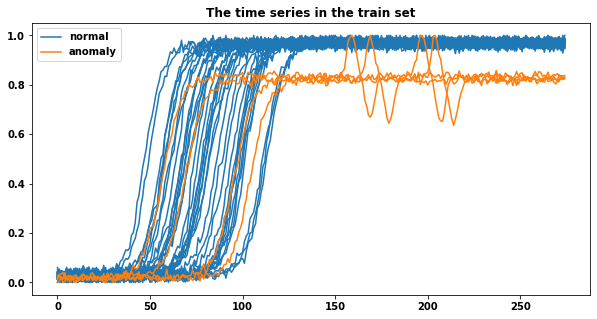

In [11]:
plt.figure(figsize=(10, 5))
for i in range(len(X_train_anomaly[y_train_anomaly==1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:blue', label='normal' if i==0 else None)
for i in range(len(X_train_anomaly[y_train_anomaly==-1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==-1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:orange', label='anomaly' if i==0 else None)
plt.legend()
plt.title('The time series in the train set', fontweight="bold")
plt.show()
# plt.savefig('trace34_train')


## BruteForce algorithm 

Set up the parameters:

In [15]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)

K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)
K = round(K_star*Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = True
corr_threshold = 0.8
pos_boundary = None

# extract the shapelets
shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse, sample_size=3000)
S = shapelets.sequences
np.save(f'../Results/Trace34/s_reverse=pos_boundary={pos_boundary}_corr_threshold={corr_threshold}', S)

Are going to be extracted 6 shapelets of length 55
Shapelets are going to be extracted in reverse order!


timeseries: 100%|██████████| 44/44 [32:46<00:00, 44.69s/it]


Candidates are being filtered by a correlation threshold of 0.8
Time for shapelets extraction:
--- 1985.584753036499 seconds ---


Try with other parameters:

In [22]:
# try with other parameters 
pos_boundary = 20
corr_threshold = None
shapelets = extractor.get_top_candidates(K, pos_boundary, corr_threshold, reverse, sample_size=3000)
S = shapelets.sequences
np.save(f'results/Trace34/s_reverse=pos_boundary={pos_boundary}_corr_threshold={corr_threshold}', S)


Candidates are being filtered by a position threshold of 20 time steps


Load the results:

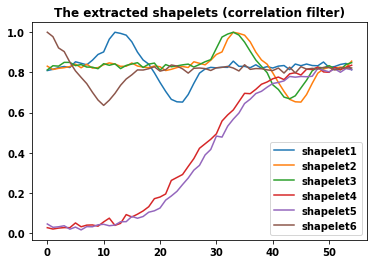

In [23]:
# or load the results
S = np.load(f'results/Trace34/s_reverse=pos_boundary={pos_boundary}_corr_threshold={corr_threshold}.npy')
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets (correlation filter)', fontweight="bold")
plt.show()
# plt.savefig('trace34_shapelets_distancefilter')

## Anomaly detection using SVDD

Transform the dataset:

In [25]:
X_train_transform, X_test_transform = extractor.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)
n_shap = 1 # take only first shapelet
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]

Type and shape of transformed train data <class 'numpy.ndarray'> (44, 6)
Type and shape of transformed test data <class 'numpy.ndarray'> (56, 6)


Fit the OCSVM:

In [26]:
ocsvm = OneClassSVM(nu=alpha, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, -y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)

Test balanced accuracy: 0.65
Test AUC: 1.0
Test F1 score: 0.9292929292929293


Confusion matrix

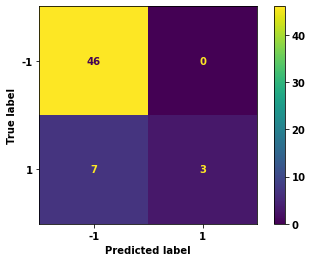

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()
plt.show()